**Classifying diseases based on the gut micobiota (GM) data**

In this notebook file, we will demonstrate how the classification accuracies varies for different data sizes. Here, we will be using four machine learning (ML) algorithms, including random forest (RF), support vector machine (SVM), artificial neural networks (ANN), and convolutional neural networks (CNN). Furthermore, we are looking into four different problems: 
 
**classifying 5 conditions Crohn's disease (CD), ulcerative colitis (UC), Parkinson's disease (PD), human immuno deficiency virus (HIV), healthy control (HC):** We want to see whether it is possible to distinguish between diseases such as UC, which is mostly present in the gastrointestinal tract, and other diseases, such as PD, which mostly harbors the brain. All the mentioned diseases have been reported to induce conformational changes in GM. 



**Investigating the effects of the size of data on the accuracy of different ML algorithms**

Here we pick 15 samples with different sizes from the data and analyze how classification accuracy metrics vary as a function of size using 5-fold cross-validation when classifying the five conditions.

In [ ]:
#import all the required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import os as os
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler 
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll
import time as time
from sklearn.neighbors import kneighbors_graph
from sklearn import mixture
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
from sklearn.utils import shuffle
import random
from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm
from sklearn.model_selection import train_test_split
import matplotlib
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

In [ ]:
####specify the output and input directories #########

Results_dir='/content/drive/MyDrive/food_science_disease_prediction/For_GitHub/Results_GitHub'##specify where you want all the results to be saved
data_fiber=pd.read_csv("/content/drive/MyDrive/food_science_disease_prediction/For_GitHub/Data_GitHub/Data_fiber.csv")#input directory for the data that contains all the subjects with and without fiber treatments
data_baseline=pd.read_csv('/content/drive/MyDrive/food_science_disease_prediction/For_GitHub/Data_GitHub/Data_baseline.csv') #input directory for the Feces data that contains the subjects without fiber treatments

In [ ]:
###define convolutional functions for CNN
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)
  
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

###The block using for CNN  
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes=1, planes=3, num_classes_condition=5, data_len=100, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        self.data_len = data_len
        self.num_classes_condition = num_classes_condition
        self.fc_2 = nn.Linear(self.data_len * planes, self.data_len)
        self.fcc_2 = nn.Linear(self.data_len, self.num_classes_condition)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        ######
        #identity=out
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out = self.relu(out)
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out += identity
        #out = self.relu(out)
        ###########
        ######
        #identity=out
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out = self.relu(out)
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out += identity
        #out = self.relu(out)

        out_2 = out.view(out.size(0), -1)


        out_2 = self.fc_2(out_2)
        out_2 = self.relu(out_2)
        out_2 = self.fcc_2(out_2)
        return out_2


class myDataset(Dataset):
  def __init__(self,X,Y,transform=None):
    self.x = X
    self.y = Y
    self.transform = transform
    
  def __len__(self):
    return len(self.y)
  
  def __getitem__(self,index):
    input = self.x[index].reshape(1,-1).astype(np.float32)
    # label = self.class2idx[self.y[index]]
    labels_condition = self.y[index][0]
    return {'input':torch.from_numpy(input), 'labels_condition':torch.as_tensor(labels_condition, dtype=torch.torch.int64)}


### Define a class for saving the results to understand how accuracies vary for different sizes as well as 

## available methods are RF, SVM, ANN, CNN
## input_data can be either the whole data or data without fiber treatment
## number_of_smaples you want to have 
class accuracy_size:
      def __init__(self,output_dir,input_data,input_data_type, method, number_of_smaples=15,ssave='True'):
          self.data=input_data.copy()
          self.method=method
          sizes_of_iterest=np.linspace(len(input_data)/number_of_smaples,len(input_data),number_of_smaples)
          self.sizes_of_iterest=sizes_of_iterest.astype(int)
          self.save=ssave
          self.output_dir=output_dir
          self.input_data_type=input_data_type
          self.input_data_type=input_data_type
      def get_accuracies_sklearn(self):
          accuracies=dict()
          if self.method=='RF':
             model=RandomForestClassifier(max_depth= 20, max_features =2, min_samples_split= 2, n_estimators= 500, random_state=10)
          elif self.method=='SVM':
             model=SVC(C=500,random_state=10,decision_function_shape='ovr',probability=True)
          elif self.method=='ANN':
             model = MLPClassifier(activation= 'tanh', alpha= 0.05, hidden_layer_sizes= (60, 60, 60, 60), learning_rate= 'constant', solver= 'adam',random_state=10)
          ###choosing data size 
          total_accuracies=dict()
          for size_of_interest in self.sizes_of_iterest:
              data = self.data.copy()
              random.seed(1)
              ns=[]
              while len(ns)<size_of_interest:
                     n=random.randint(0, len(data)-1)
                     if not n in ns:
             
                        ns.append(n)   
              ##sample the data
              data=data.iloc[ns,:]
              end_index=data.columns.get_loc("unassigned unassigned")+1
              start_index=data.columns.get_loc("Abiotrophia")
              
             ###define to dictionatoes to obtain labels from conditions and vice versa
              condition_to_labels={}
              labels_to_condition={}
              for i in range(len(data)):
                  if not data['condition'].iloc[i] in condition_to_labels:
                     condition_to_labels[data['condition'].iloc[i]]=data['condition_codes'].iloc[i]                       
              for i in range(len(data)):
                  if not data['condition_codes'].iloc[i] in labels_to_condition:
                     labels_to_condition[data['condition_codes'].iloc[i]]=data['condition'].iloc[i]
              ##sort data alphabetically        
              condition_to_labels = dict(sorted(condition_to_labels.items(), key=lambda item: item[1]))
              X=data.iloc[:,start_index:end_index].values
              ####choos 'condition_codes' as the column of interest for the output prediction
              columns_of_interest=['condition_codes']
              Y=data[columns_of_interest].values
              ###use 5-fold cross validation
              cv=KFold(n_splits=5,shuffle=True,random_state=42)
              accuracy=[]
              for ii, (train, test) in enumerate(cv.split(X, Y)):
                  X_train=X[train]
                  Y_train=Y[train]
                  X_test=X[test]
                  Y_test=Y[test]
                  true_labels_condition = Y_test
                  model.fit(X_train,Y_train)
                  Y_pred=model.predict(X_test)
                  predictions_labels_conditions=Y_pred           
                  predictions_labels_conditions=np.array(predictions_labels_conditions).reshape(-1,1)
                  accuracy.append(accuracy_score(true_labels_condition, predictions_labels_conditions))
              accurcay=np.array(accuracy)
              accuarcy_5_fold_mean=accurcay.mean()
              total_accuracies[size_of_interest]=accuarcy_5_fold_mean

          if self.save:
             out_dir=self.output_dir+'/accuracies_vs_size'
             if not os.path.exists(out_dir):
                os.mkdir(out_dir)
             accuracies_Dic={}  
             for key in total_accuracies.keys():
                 accuracies_Dic['data_size='+str(key)]=total_accuracies[key]
             accuracies_DF=pd.DataFrame(accuracies_Dic,index=[0]) 
             accuracies_DF.to_csv(out_dir+'/'+'accuracies_{}_{}.csv'.format(self.method,self.input_data_type),index=False)  
          return total_accuracies
      def get_accuracies_Torch(self):
          self.method='CNN'
          accuracies=dict() 
          total_accuracies=dict()
          for size_of_interest in self.sizes_of_iterest:
              print('data_size=',size_of_interest,' done!')
              data = self.data.copy()
              random.seed(1)
              #include these number to make sure that HIV patients and thereby all the classes are present in the training section
              ns=[90,136,137]
              while len(ns)<size_of_interest:
                     n=random.randint(0, len(data)-1)
                     if not n in ns:
                        ns.append(n)
              data=data.iloc[ns,:]
              end_index=data.columns.get_loc("unassigned unassigned")+1
              start_index=data.columns.get_loc("Abiotrophia") 
              condition_to_labels={}
              labels_to_condition={}
              for i in range(len(data)):
                  if not data['condition'].iloc[i] in condition_to_labels:
                     condition_to_labels[data['condition'].iloc[i]]=data['condition_codes'].iloc[i]
  
              for i in range(len(data)):
                  if not data['condition_codes'].iloc[i] in labels_to_condition:
                     labels_to_condition[data['condition_codes'].iloc[i]]=data['condition'].iloc[i]           
              condition_to_labels = dict(sorted(condition_to_labels.items(), key=lambda item: item[1]))
              num_classes_condition=len(condition_to_labels)
              X=data.iloc[:,start_index:end_index].values
              ####choos 'condition_codes' as the column of interest for the output prediction
              columns_of_interest=['condition_codes']
              Y=data[columns_of_interest].values
              ###use 5-fold cross validation
              cv=KFold(n_splits=5,shuffle=True,random_state=42)
              accuracy=[]  
              for ii, (train, test) in enumerate(cv.split(X, Y)):
                  X_train=X[train]
                  Y_train=Y[train]
                  X_test=X[test]
                  Y_test=Y[test]
                  train_dataset = myDataset(X_train,Y_train)
                  test_dataset = myDataset(X_test,Y_test)
                  train_data_loader = DataLoader(dataset = train_dataset,batch_size =20,shuffle =True,num_workers=2)
                  test_data_loader = DataLoader(dataset = test_dataset,batch_size =1000,shuffle =False,num_workers=2)
                  seed = 0
                  random.seed(seed)
                  torch.manual_seed(seed)
                  device = torch.device ("cuda:0" if torch.cuda.is_available () 
                                  else "cpu")
                  net = BasicBlock(inplanes=1, planes=3, num_classes_condition=num_classes_condition, data_len=X.shape[1], stride=1, downsample=None, groups=1,
                     base_width=64, dilation=1, norm_layer=None)
                  net = net.to(device)
                  criterion = nn.CrossEntropyLoss()
                  optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.1)
                  #play with the poch size, for more accurate results, set it to 500, but it will take a couple of hours
                  epochs=500
                  loss_tot_condition=[]
                  loss_condition_train=[]
                  loss_condition_test=[]
                  eepoch=[]
                  for epoch in range(epochs):
                      my_loss_condition = 0.0
                      eepoch.append(epoch+1)
                      for k, data in enumerate(train_data_loader):
                          inputs,  labels_condition = data["input"], data["labels_condition"]
                          inputs = inputs.to(device)
                          labels_condition = labels_condition.to(device)
                          optimizer.zero_grad()
                          outputs = net(inputs)
                          outputs_condition_label = outputs
                          loss_condition = criterion(outputs_condition_label, labels_condition)
                          loss_condition.backward(retain_graph=True)
                          optimizer.step()
                          my_loss_condition += loss_condition.item()
                  for k, data in enumerate(test_data_loader):
                          inputs,  labels_condition = data["input"], data["labels_condition"]
                          inputs = inputs.to(device)
                          labels_condition = labels_condition.to(device)
                          #optimizer.zero_grad()
                          outputs = net(inputs)
                          Y_scores = torch.sigmoid(outputs)
                          outputs_condition_label = outputs
                  predictions_labels_conditions = []
                  for j in range(outputs_condition_label.shape[0]):
                      predictions_labels_conditions.append(torch.argmax(outputs_condition_label[j]).cpu().numpy().item())
                  predictions_labels_conditions=np.array(predictions_labels_conditions).reshape(-1,1) 
                  accuracy.append(accuracy_score(Y_test, predictions_labels_conditions))
              accuracy=np.array(accuracy)    
              accuarcy_5_fold_mean=accuracy.mean()
              total_accuracies[size_of_interest]=accuarcy_5_fold_mean
              if self.save:
                 out_dir=self.output_dir+'/accuracies_vs_size'
                 if not os.path.exists(out_dir):
                    os.mkdir(out_dir)
              accuracies_Dic={}  
              for key in total_accuracies.keys():
                  accuracies_Dic['data_size='+str(key)]=total_accuracies[key]
              accuracies_DF=pd.DataFrame(accuracies_Dic,index=[0]) 
              accuracies_DF.to_csv(out_dir+'/'+'accuracies_{}_{}.csv'.format(self.method,self.input_data_type),index=False) 
          return total_accuracies

In [ ]:
data = data_fiber.copy()
instant_RF=accuracy_size(Results_dir,data,'fiber','RF',15,True)
instant_SVM=accuracy_size(Results_dir,data,'fiber','SVM',15,True)
instant_ANN=accuracy_size(Results_dir,data,'fiber','ANN',15,True)

RF_accuracies=instant_RF.get_accuracies_sklearn()
SVM_accuracies=instant_SVM.get_accuracies_sklearn()
ANN_accuracies=instant_ANN.get_accuracies_sklearn()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: DataConversionWarning: A column-vector y was passe

In [ ]:
instant_CNN=accuracy_size(Results_dir,data,'fiber','CNN',15,True)
CNN_accuracies=instant_CNN.get_accuracies_Torch()

data_size= 72  done!
data_size= 145  done!
data_size= 218  done!
data_size= 291  done!
data_size= 364  done!
data_size= 436  done!
data_size= 509  done!
data_size= 582  done!
data_size= 655  done!
data_size= 727  done!
data_size= 800  done!
data_size= 873  done!
data_size= 946  done!
data_size= 1019  done!
data_size= 1092  done!


In [ ]:

import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

sizes_of_interest=list(RF_accuracies.keys())

data_RF=list(RF_accuracies.values())
data_ANN=list(ANN_accuracies.values())
data_SVM=list(SVM_accuracies.values())
data_CNN=list(CNN_accuracies.values())

plt.figure(figsize=(10, 8))
plt.plot(sizes_of_interest,data_SVM,'-o', markersize=15,label='SVM')
plt.plot(sizes_of_interest,data_RF,'-*',markersize=15,label='RF')
plt.plot(sizes_of_interest,data_ANN,'-s',markersize=15,label='ANN')
plt.plot(sizes_of_interest,data_CNN,'-^',markersize=15,label='CNN')

plt.xlabel("data size",fontsize=20)
plt.ylabel("accuracy",fontsize=20)
plt.title('Effects of data size on the accuracy of different algorithms',fontsize=20)
plt.legend(fontsize=20)



In [ ]:
data = data_baseline.copy()

instant_RF=accuracy_size(Results_dir,data,'baseline','RF',15,True)
instant_SVM=accuracy_size(Results_dir,data,'baseline','SVM',15,True)
instant_ANN=accuracy_size(Results_dir,data,'baseline','ANN',15,True)


RF_accuracies=instant_RF.get_accuracies_sklearn()
SVM_accuracies=instant_SVM.get_accuracies_sklearn()
ANN_accuracies=instant_ANN.get_accuracies_sklearn()


In [ ]:
data = data_baseline.copy()
instant_CNN=accuracy_size(Results_dir,data,'baseline','CNN',15,True)
CNN_accuracies=instant_CNN.get_accuracies_Torch()

data_size= 9  done!
data_size= 18  done!
data_size= 27  done!
data_size= 36  done!
data_size= 46  done!
data_size= 55  done!
data_size= 64  done!
data_size= 73  done!
data_size= 82  done!
data_size= 92  done!
data_size= 101  done!
data_size= 110  done!
data_size= 119  done!
data_size= 128  done!
data_size= 138  done!


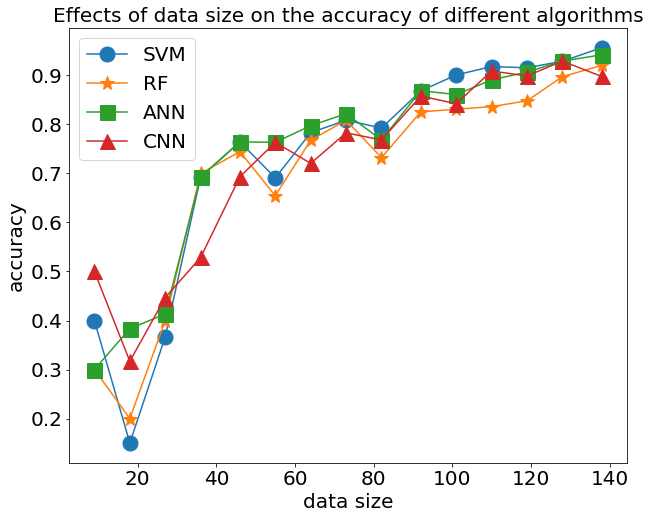

In [ ]:

import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

sizes_of_interest=list(CNN_accuracies.keys())

data_RF=list(RF_accuracies.values())
data_ANN=list(ANN_accuracies.values())
data_SVM=list(SVM_accuracies.values())
data_CNN=list(CNN_accuracies.values())

plt.figure(figsize=(10, 8))
plt.plot(sizes_of_interest,data_SVM,'-o', markersize=15,label='SVM')
plt.plot(sizes_of_interest,data_RF,'-*',markersize=15,label='RF')
plt.plot(sizes_of_interest,data_ANN,'-s',markersize=15,label='ANN')
plt.plot(sizes_of_interest,data_CNN,'-^',markersize=15,label='CNN')


plt.xlabel("data size",fontsize=20)
plt.ylabel("accuracy",fontsize=20)
plt.title('Effects of data size on the accuracy of different algorithms',fontsize=20)
plt.legend(fontsize=20)
